In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import torch

## Get the Dataset from file

In [2]:
filename = "../data/"
rawdata = h5py.File(filename+'ViSAPy_nonfiltered.h5','r')

In [3]:
print(rawdata['data'])

<HDF5 dataset "data": shape (1200001, 102), type "<f4">


## What is the data?

In [4]:
for i in range(5):
    for j in range(6):
        print(rawdata['data'][i][j], end=" ")
    print("\n")

0.004788064 -0.01826318 0.003492297 -0.032078348 -0.010203197 0.0066871587 

0.0037384066 -0.026971504 -0.0045002163 -0.03491524 -0.007150419 0.012898053 

0.0030027581 -0.025864465 -0.0066695386 -0.029838692 -0.0024219453 0.009391305 

-0.003965647 -0.02545898 -0.00031221227 -0.032533586 -0.0057233935 0.01265745 

-0.009700247 -0.02288886 0.0022615287 -0.01949341 2.8031296e-05 0.012613925 



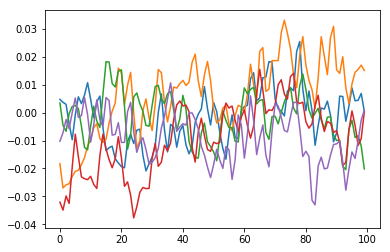

In [5]:
etrode_1 = rawdata['data'][:100, 0]

plt.figure()
for i in range(5):
    etrode_1 = rawdata['data'][:100, i]
    plt.plot(etrode_1)
plt.show()

## Desigining the autoencoder

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)

In [7]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 1024),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(1024, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256,4))
        self.decoder = nn.Sequential(nn.Linear(4, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, input_size),
                                     nn.Tanh())
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def forward_numpy(self, x):
        #x = torch.from_numpy(x).float().cuda()
        enc, dec = self.forward(x)
        return dec

In [8]:
import numpy as np

max_length = 100001
length = 100
base_feat_length = 101
features = 70000
np.random.seed(5132)

#electrode_data = np.zeros([length, features])

for i in range(features):
    start = np.random.randint(0, max_length)
    selected_trode = np.random.randint(0, base_feat_length)
    #electrode_data[:, i] = rawdata['data'][start:start+length, selected_trode]
#print(electrode_data)

In [10]:
#np.save('mydata_100', electrode_data)
electrode_data = np.load('mydata_100.npy')
print(electrode_data.shape[1])

70000


In [11]:
import random

def train(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[1]), batch_size)
        for feats in selected:
            x = input_data[:, feats]
            #print(x)
            x = np.append(x, 1)
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            out = model.forward_numpy(x)
            out = torch.tensor(out).float().cuda()
            #print(type(torch.from_numpy(out).float().cuda()), type(x))
            loss = criterion(out, x)
            #print(loss)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
    return out

In [155]:
epoch_range = 100
batch_size = 500
learning_rate = 0.00001

model = autoencoder(length+1).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

out = train(model, electrode_data, criterion, optimizer, epoch_range, batch_size)

/home/sambit/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/100], loss:0.0004639
epoch [2/100], loss:0.0003158
epoch [3/100], loss:0.0004277
epoch [4/100], loss:0.0003896
epoch [5/100], loss:0.0003485
epoch [6/100], loss:0.0002931
epoch [7/100], loss:0.0003851
epoch [8/100], loss:0.0001438
epoch [9/100], loss:0.0001965
epoch [10/100], loss:0.0001917
epoch [11/100], loss:0.0001780
epoch [12/100], loss:0.0004342
epoch [13/100], loss:0.0001305
epoch [14/100], loss:0.0001412
epoch [15/100], loss:0.0001288
epoch [16/100], loss:0.0001214
epoch [17/100], loss:0.0001106
epoch [18/100], loss:0.0001218
epoch [19/100], loss:0.0000911
epoch [20/100], loss:0.0000738
epoch [21/100], loss:0.0000790
epoch [22/100], loss:0.0001372
epoch [23/100], loss:0.0000792
epoch [24/100], loss:0.0002316
epoch [25/100], loss:0.0003440
epoch [26/100], loss:0.0001439
epoch [27/100], loss:0.0001305
epoch [28/100], loss:0.0000732
epoch [29/100], loss:0.0000831
epoch [30/100], loss:0.0008397
epoch [31/100], loss:0.0000933
epoch [32/100], loss:0.0001365
epoch [33/100], l

In [156]:
out = (out.data).cpu().numpy()
print(out.shape)

(101,)


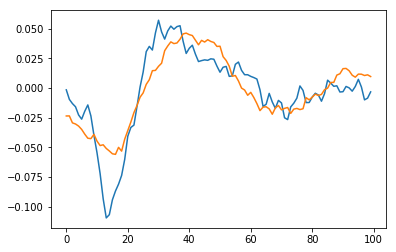

In [163]:
n = 216
data = electrode_data[:100, n]
data = np.append(data, 1)
#print(data)
data = torch.from_numpy(data).float().cuda()
o = model.forward_numpy(data).cuda()
o = (o.data).cpu().numpy()
#print(electrode_data[:30, 0]-o[:30])
#print(o)
plt.figure()
plt.plot(electrode_data[:100, n])
plt.plot(o[:100])
plt.show()

In [168]:
class UpAE(nn.Module):
    def __init__(self, input_size):
        super(UpAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 1024),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(1024, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256,4))
        self.decoder = nn.Sequential(nn.Linear(4, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Dropout(p=0.1),
                                     nn.Linear(512, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, input_size),
                                     nn.ELU(),
                                     nn.Linear(input_size, input_size*2),
                                     nn.Tanh())
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def forward_numpy(self, x):
        #x = torch.from_numpy(x).float().cuda()
        enc, dec = self.forward(x)
        return dec

In [169]:
import random

def train(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[1]), batch_size)
        for feats in selected:
            x = input_data[:, feats]
            #print(x)
            x = np.append(x, 1)
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            out = model.forward_numpy(x)
            out = torch.tensor(out).float().cuda()
            #print(type(torch.from_numpy(out).float().cuda()), type(x))
            loss = criterion(out, x)
            #print(loss)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
    return out

In [170]:
epoch_range = 100
batch_size = 500
learning_rate = 0.00001

model = UpAE(length+1).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

out = train(model, electrode_data, criterion, optimizer, epoch_range, batch_size)

RuntimeError: input and target shapes do not match: input [202], target [101] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/THCUNN/generic/MSECriterion.cu:15

In [ ]:
n = 216
p = 100
data = electrode_data[:p, n]
data = np.append(data, 1)
#print(data)
data = torch.from_numpy(data).float().cuda()
o = model.forward_numpy(data).cuda()
o = (o.data).cpu().numpy()
#print(electrode_data[:30, 0]-o[:30])
#print(o)
plt.figure()
plt.plot(electrode_data[:p, n])
xt = np.arange(0, p, step=0.5)
plt.plot(xt, o[:p*2])
plt.show()